In [120]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

In [121]:
def lame_parameters(vp,vs,rho):
    M = vs*vs*rho
    L = vp*vp*rho - 2*M
    return L,M

In [215]:
def build_ricker(time,freq):
    ricker = np.zeros(len(time))
    t0     = 1.4*np.sqrt(6)/(np.pi*freq)
    a2     = (np.pi*freq*(time-t0))**2
    ricker = (1.-2.*a2)*np.exp(-a2)
    return ricker


In [216]:
def build_gaussian(time,freq,alpha):
    gaussian = np.zeros(len(time))
    t0     = np.sqrt(6)/(np.pi*freq)
    gaussian = np.exp(-alpha*(time-t0)**2)
    return gaussian

In [217]:
def build_derivate_gaussian(time,freq,alpha):
    der_gauss = np.zeros(len(time))
    t0     = np.sqrt(6)/(np.pi*freq)
    der_gauss =  (-2*alpha*(time-t0)**2) * (np.exp(-alpha*(time-t0)**2))
    return der_gauss

In [218]:
def fdtd(vp,vs,rho,nx,nz,nt,source1,sx,sz,dx,dt):
    #buoyoncy 
    B     = 1/rho
    #paramatres de Lamé
    L,M   = lame_parameters(vp,vs,rho)    #Lambda 1st lame coef ,  M 2nd parameters

    #initial conditions for velocity
    U     = np.zeros([nz,nx,nt])
    V     = np.zeros([nz,nx,nt])
    
    #initial conditions for stress
    Sigma = np.zeros([nz,nx,nt])
    T     = np.zeros([nz,nx,nt])
    Ksi   = np.zeros([nz,nx,nt])
    

    
    for it in range(1,len(source1)):
        #displacement composant
        for iz in range(1,nx-1):
            for ix in range(1,nz-1):
                U[iz,ix,it]        =   U[iz,ix,it-1]        +       (B*dt/dx)     *  (Sigma[iz,ix,it-1] - Sigma[iz,ix-1,it-1])      +  (B*dt/dz)   * (Ksi[iz,ix,it-1] -  Ksi[iz-1,ix,it-1])    
        
        #U[sz,sx,it]       =  U[sz,sx,it]   +  source1[it]/(dx*dx*dt)
        
        for iz in range(1,nx-1):
            for ix in range(1,nz-1): 
                V[iz,ix,it]        =   V[iz,ix,it-1]        +       (B*dt/dx)     *  (Ksi[iz,ix+1,it-1]   - Ksi[iz,ix,it-1])        +  (B*dt/dz)   * (T[iz+1,ix,it-1]   -  T[iz,ix,it-1])        
                
        #Stress composant   
        for iz in range(1,nx-1):
            for ix in range(1,nz-1):
                Sigma[iz,ix,it]    = Sigma[iz,ix,it-1]      +    (L+2*M) * (dt/dx) * (U[iz,ix+1,it] - U[iz,ix,it])                  +  L * (dt/dz) * (V[iz,ix,it]     -  V[iz-1,ix,it])     
        Sigma[sz,sx,it]       =  Sigma[sz,sx,it]   +  source1[it]/(dx*dx*dt)
        for iz in range(1,nx-1):
            for ix in range(1,nz-1):
                T[iz,ix,it]        = T[iz,ix,it-1]          +    (L+2*M) * (dt/dz) * (V[iz,ix,it] - V[iz-1,ix,it])                  +  L * (dt/dx) * (U[iz,ix+1,it]     -  U[iz,ix,it])      
        T[sz,sx,it]       =  T[sz,sx,it]   +  source1[it]/(dx*dx*dt)
        for iz in range(1,nx-1):
            for ix in range(1,nz-1):
                Ksi[iz,ix,it]      = Ksi[iz,ix,it-1]        +    (M)     * (dt/dz) * (U[iz+1,ix,it] - U[iz,ix,it])                  +  M * (dt/dx) * (V[iz,ix,it]     -  V[iz,ix-1,it])    
                
                
                
        #source        

        #V[sz,sx,it]       =  V[sz,sx,it]   +  source[it]
        #article say that the source function is applied just on the stress component
        #Sigma[sz,sx,it]   =  Sigma[sz,sx,it]   +  source1[it] 
        #T[sz,sx,it]       =  T[sz,sx,it]   +  source1[it]
        #Ksi[sz,sx,it]     =  Ksi[sz,sx,it]   +  source2[it]
        # I have to separate this 2 sources because the second source is applied when we are near to the surface
        
    return Sigma,T,Ksi,U,V

In [241]:
#########################################################################
#-----------------------------Parameter---------------------------------#
#########################################################################

vp   = 8                    # vitesse onde P km/s
vs   = int(vp/np.sqrt(3))   # vitesse onde S km/s

#----------les parametres qui doivent faire varier mon modele-----------#
freq = 5                    # Hz
rho  = 2500/1e9             # densité kg/km^3




#---------------------la taille du modele------------------------------#
lx = 4                    # km
lz = 4                    # km

#-----------------------les pas d'espace-------------------------------#
dx = vs/(freq*20)    # le x20 permet de considérer 20 points par longueur d'onde 
dz = dx

#-----------------la taille du modele version numérique----------------#
nx = int(np.floor(lx/dx+1))
nz = int(np.floor(lz/dx+1))

#--------------------------source parameters---------------------------#
T_record =  1                        # la durée de l'enregistrement (seconde)
stab_condition = dx/(vp)
dt       =  stab_condition/np.sqrt(2)   # le pas de temps la condition de stabilité implique que : dt < dx/(vp*sqrt(2))
time     =  np.arange(0,T_record,dt)
nt       =  len(time)

#-------------------------les types de sources-------------------------#
gaussian  =  build_gaussian(time,freq,alpha=200)            # <= alpha have to equal to 200
der_gauss =  build_derivate_gaussian(time,freq,alpha=40)    # <= alpha have to equal to 40
ricker    =  build_ricker(time,freq)
#--------------------localisation de la source-------------------------#
sx = 31                    #localisation source x axis
sz = 31                   #localisation source z axis

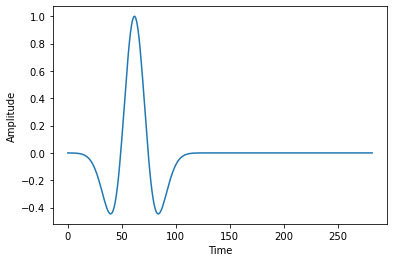

In [242]:
#plt.plot(der_gauss)
#plt.plot(gaussian)
#plt.plot(gaussian+der_gauss)
plt.plot(ricker)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.savefig("Ricker.png")
#plt.plot(ricker)

In [243]:
#####################################################################
#----------------Résolution en différences finies-------------------#
#####################################################################

Sigma,T,Ksi,U,V = fdtd(vp,vs,rho,nx,nz,nt,ricker,sx,sz,dx,dt)

In [244]:
print("nombre d'indices t :%s" %(T.shape[2]))

nombre d'indices t :283


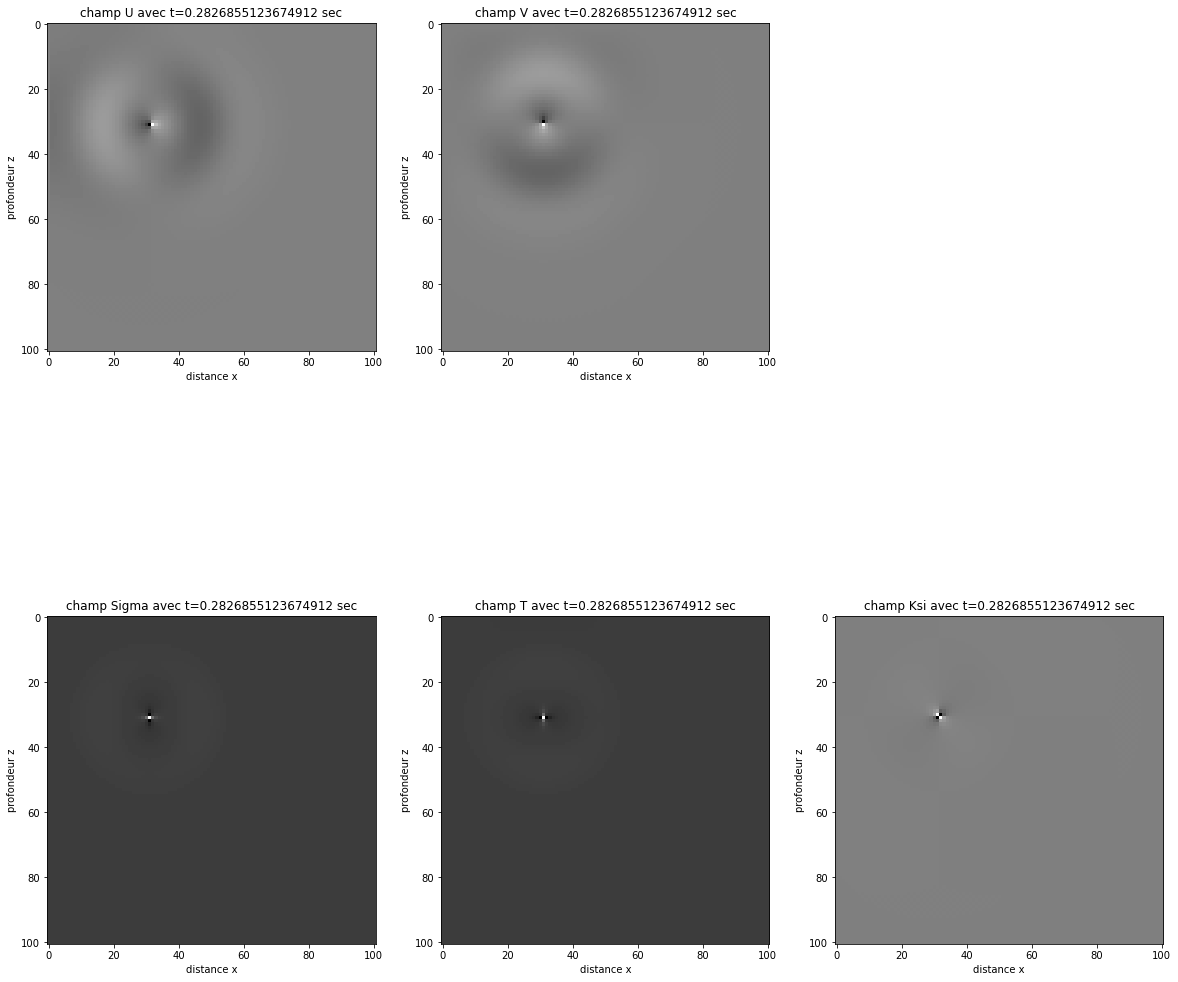

In [308]:
########################################################################
#-------------------Les différents champs calculés---------------------#
########################################################################

t=80      #itération temps considéré
timing = t*T_record/T.shape[2]
fig = plt.figure(figsize=(20,20))




axis1 = fig.add_subplot(231)
axis1.set_ylabel('profondeur z')
axis1.set_xlabel('distance x')
axis1.set_title("champ U avec t=%s sec"%timing)
axis1.imshow(U[:,:,t],cmap='gray')

axis2 = fig.add_subplot(232)
axis2.set_ylabel('profondeur z')
axis2.set_xlabel('distance x')
axis2.set_title("champ V avec t=%s sec"%timing)
axis2.imshow(V[:,:,t],cmap='gray')



axis3 = fig.add_subplot(234)
axis3.set_ylabel('profondeur z')
axis3.set_xlabel('distance x')
axis3.set_title("champ Sigma avec t=%s sec"%timing)
axis3.imshow(Sigma[:,:,t],cmap='gray')


axis4 = fig.add_subplot(235)
axis4.set_ylabel('profondeur z')
axis4.set_xlabel('distance x')
axis4.set_title("champ T avec t=%s sec"%timing)
axis4.imshow(T[:,:,t],cmap='gray')


axis5 = fig.add_subplot(236)
axis5.set_ylabel('profondeur z')
axis5.set_xlabel('distance x')
axis5.set_title("champ Ksi avec t=%s sec"%timing)
axis5.imshow(Ksi[:,:,t],cmap='gray')

fig.savefig('champ_t_%s'%t)

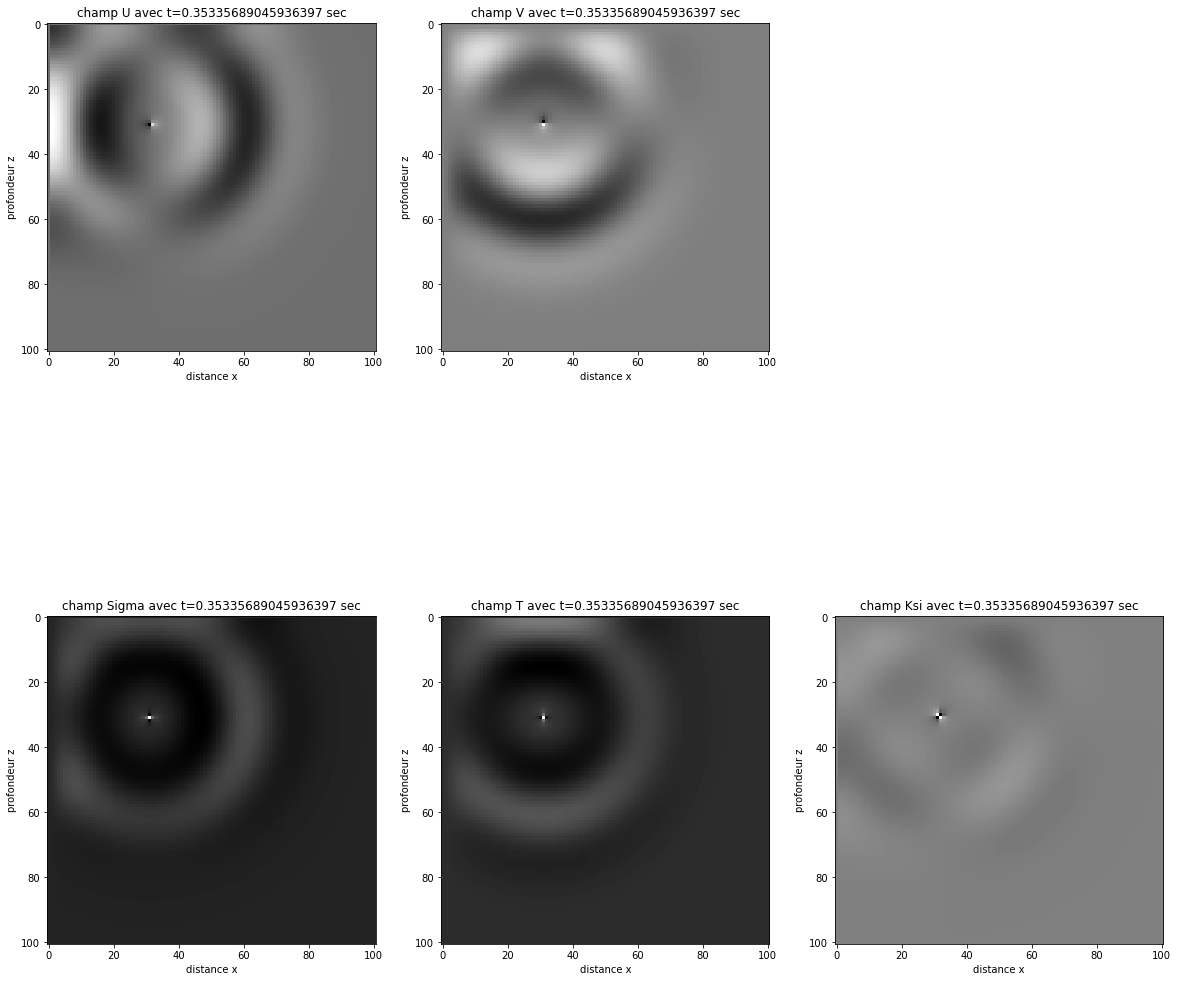

In [309]:
########################################################################
#-------------------Les différents champs calculés---------------------#
########################################################################

t=100      #temps considéré
timing = t*T_record/T.shape[2]
fig = plt.figure(figsize=(20,20))




axis1 = fig.add_subplot(231)
axis1.set_ylabel('profondeur z')
axis1.set_xlabel('distance x')
axis1.set_title("champ U avec t=%s sec"%timing)
axis1.imshow(U[:,:,t],cmap='gray')

axis2 = fig.add_subplot(232)
axis2.set_ylabel('profondeur z')
axis2.set_xlabel('distance x')
axis2.set_title("champ V avec t=%s sec"%timing)
axis2.imshow(V[:,:,t],cmap='gray')



axis3 = fig.add_subplot(234)
axis3.set_ylabel('profondeur z')
axis3.set_xlabel('distance x')
axis3.set_title("champ Sigma avec t=%s sec"%timing)
axis3.imshow(Sigma[:,:,t],cmap='gray')


axis4 = fig.add_subplot(235)
axis4.set_ylabel('profondeur z')
axis4.set_xlabel('distance x')
axis4.set_title("champ T avec t=%s sec"%timing)
axis4.imshow(T[:,:,t],cmap='gray')


axis5 = fig.add_subplot(236)
axis5.set_ylabel('profondeur z')
axis5.set_xlabel('distance x')
axis5.set_title("champ Ksi avec t=%s sec"%timing)
axis5.imshow(Ksi[:,:,t],cmap='gray')

fig.savefig('champ_t_%s'%t)

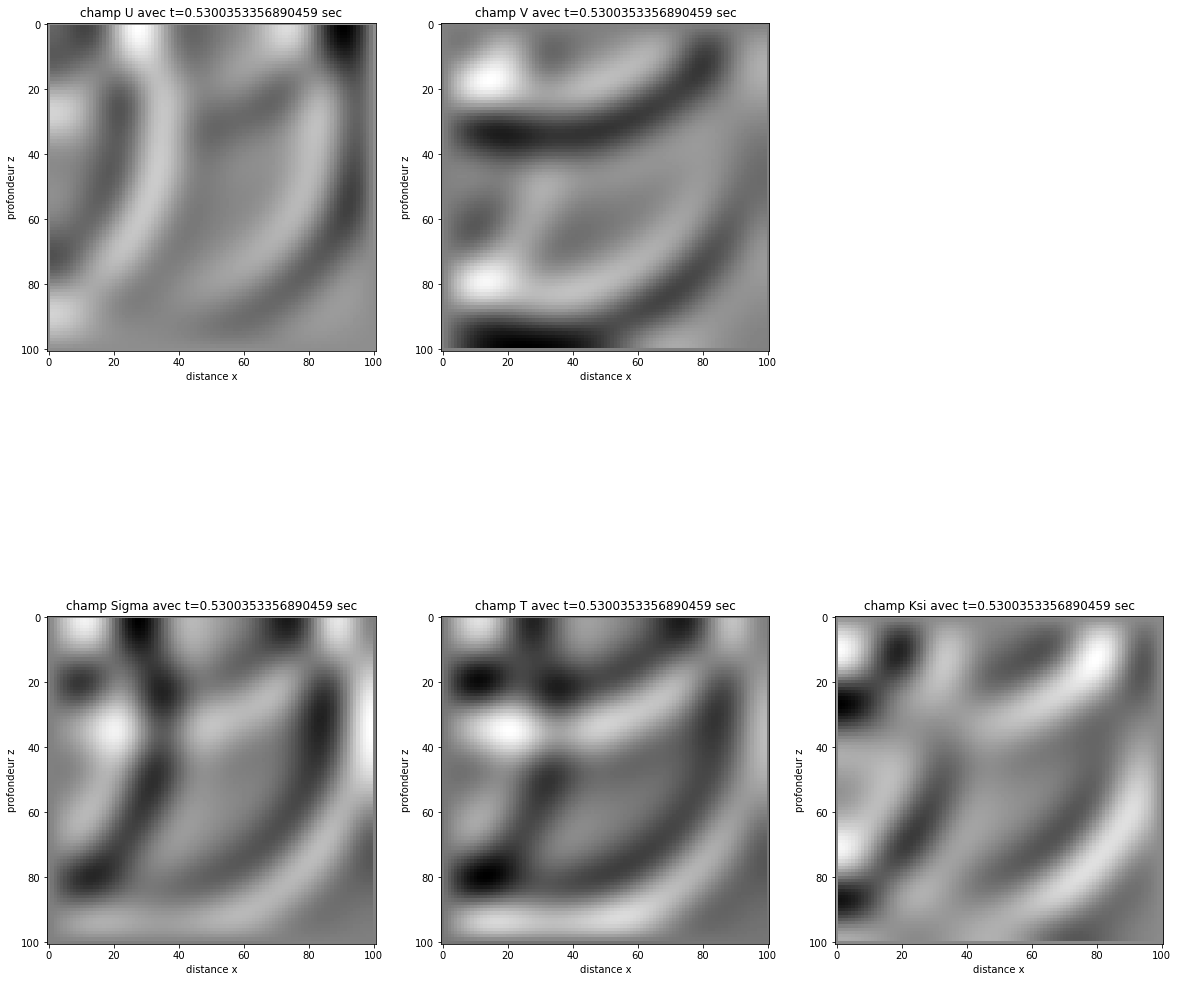

In [310]:
########################################################################
#-------------------Les différents champs calculés---------------------#
########################################################################

t=150      #temps considéré
timing = t*T_record/T.shape[2]
fig = plt.figure(figsize=(20,20))




axis1 = fig.add_subplot(231)
axis1.set_ylabel('profondeur z')
axis1.set_xlabel('distance x')
axis1.set_title("champ U avec t=%s sec"%timing)
axis1.imshow(U[:,:,t],cmap='gray')

axis2 = fig.add_subplot(232)
axis2.set_ylabel('profondeur z')
axis2.set_xlabel('distance x')
axis2.set_title("champ V avec t=%s sec"%timing)
axis2.imshow(V[:,:,t],cmap='gray')



axis3 = fig.add_subplot(234)
axis3.set_ylabel('profondeur z')
axis3.set_xlabel('distance x')
axis3.set_title("champ Sigma avec t=%s sec"%timing)
axis3.imshow(Sigma[:,:,t],cmap='gray')


axis4 = fig.add_subplot(235)
axis4.set_ylabel('profondeur z')
axis4.set_xlabel('distance x')
axis4.set_title("champ T avec t=%s sec"%timing)
axis4.imshow(T[:,:,t],cmap='gray')


axis5 = fig.add_subplot(236)
axis5.set_ylabel('profondeur z')
axis5.set_xlabel('distance x')
axis5.set_title("champ Ksi avec t=%s sec"%timing)
axis5.imshow(Ksi[:,:,t],cmap='gray')

fig.savefig('champ_t_%s'%t)

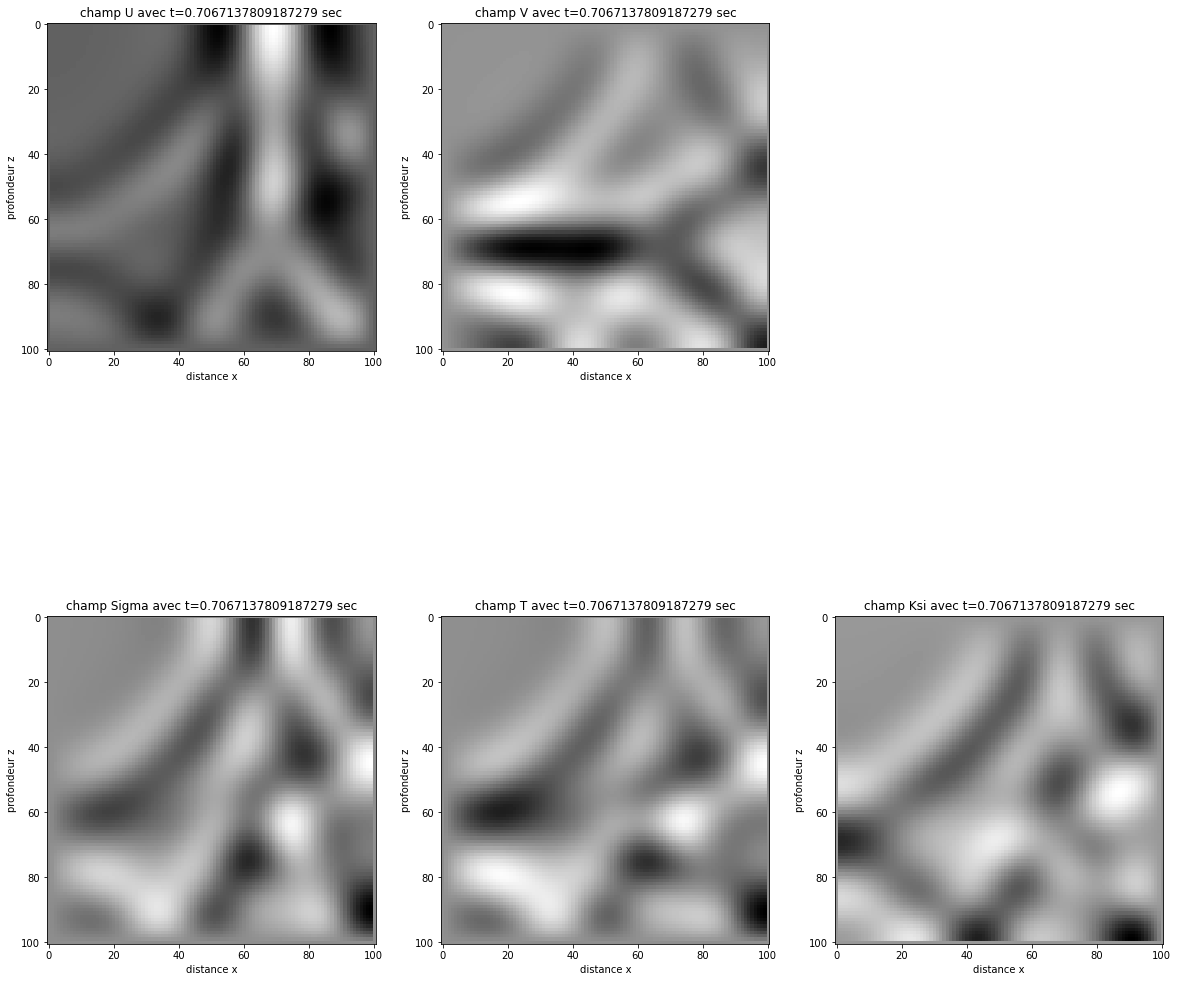

In [311]:
########################################################################
#-------------------Les différents champs calculés---------------------#
########################################################################

t=200      #temps considéré
timing = t*T_record/T.shape[2]
fig = plt.figure(figsize=(20,20))




axis1 = fig.add_subplot(231)
axis1.set_ylabel('profondeur z')
axis1.set_xlabel('distance x')
axis1.set_title("champ U avec t=%s sec"%timing)
axis1.imshow(U[:,:,t],cmap='gray')

axis2 = fig.add_subplot(232)
axis2.set_ylabel('profondeur z')
axis2.set_xlabel('distance x')
axis2.set_title("champ V avec t=%s sec"%timing)
axis2.imshow(V[:,:,t],cmap='gray')



axis3 = fig.add_subplot(234)
axis3.set_ylabel('profondeur z')
axis3.set_xlabel('distance x')
axis3.set_title("champ Sigma avec t=%s sec"%timing)
axis3.imshow(Sigma[:,:,t],cmap='gray')


axis4 = fig.add_subplot(235)
axis4.set_ylabel('profondeur z')
axis4.set_xlabel('distance x')
axis4.set_title("champ T avec t=%s sec"%timing)
axis4.imshow(T[:,:,t],cmap='gray')


axis5 = fig.add_subplot(236)
axis5.set_ylabel('profondeur z')
axis5.set_xlabel('distance x')
axis5.set_title("champ Ksi avec t=%s sec"%timing)
axis5.imshow(Ksi[:,:,t],cmap='gray')

fig.savefig('champ_t_%s'%t)

In [312]:
L,M = lame_parameters(vp,vs,rho)
%whos

Variable                  Type           Data/Info
--------------------------------------------------
Ksi                       ndarray        101x101x283: 2886883 elems, type `float64`, 23095064 bytes (22.025169372558594 Mb)
L                         float          8e-05
M                         float          4e-05
Sigma                     ndarray        101x101x283: 2886883 elems, type `float64`, 23095064 bytes (22.025169372558594 Mb)
T                         ndarray        101x101x283: 2886883 elems, type `float64`, 23095064 bytes (22.025169372558594 Mb)
T_record                  int            1
U                         ndarray        101x101x283: 2886883 elems, type `float64`, 23095064 bytes (22.025169372558594 Mb)
V                         ndarray        101x101x283: 2886883 elems, type `float64`, 23095064 bytes (22.025169372558594 Mb)
axis1                     AxesSubplot    AxesSubplot(0.125,0.594439;0.227941x0.227941)
axis2                     AxesSubplot    AxesSubplot(0

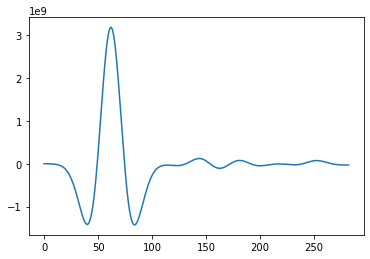

In [249]:
########################################################################
#----------------le signal enregistré dans une cellule-----------------#
########################################################################

lambda_sz = sz
lambda_sx = sx
src_model = U[lambda_sz,lambda_sx,:]
plt.plot(src_model)

In [313]:
dx

0.04

In [314]:
dt

0.0035355339059327372